In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import cv2
import numpy as np
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize
from config import BUS_DS_Config
from dataset import BUS_Dataset

Using TensorFlow backend.


**PREPARE DATASET FOR TRAINING**

In [2]:
class_names = np.array(['lesion'])

In [3]:
path_to_train_set = '/external_drive/BUS_Deep_Learning/data/seg_dir_nn/train_images'
path_to_val_set = '/external_drive/BUS_Deep_Learning/data/seg_dir_nn/val_images'
# Training dataset
dataset_train = BUS_Dataset()
dataset_train.load_data(class_names, path_to_train_set)
dataset_train.prepare()
# Validation dataset
dataset_val = BUS_Dataset()
dataset_val.load_data(class_names, path_to_val_set)
dataset_val.prepare()

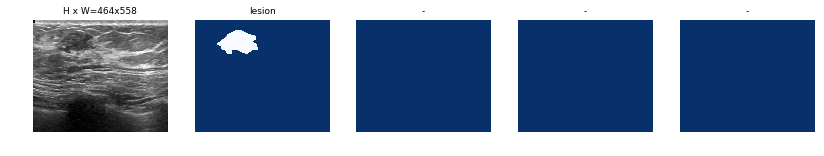

In [4]:
#Train Set
seed = 50
image = dataset_train.load_image(seed)
image = np.squeeze(image, axis=2)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
mask, class_id = dataset_train.load_mask(seed)
visualize.display_top_masks(image, mask, class_id, dataset_train.class_names)

**SET UP MODEL FOR TRAINING**

In [5]:
# Directory to save logs and trained model
# Root directory of the project
ROOT_DIR = '/external_drive/BUS_Deep_Learning/models/mask_rcnn_seg_models'
MODEL_DIR = os.path.join(ROOT_DIR, 'trained_models')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Display Model COnfiguration
config = BUS_DS_Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     32
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 32
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

**TRAIN MODEL**

In [7]:
# # Which weights to start with?
# init_with = "coco"  # imagenet, coco, or last

# if init_with == "imagenet":
#     model.load_weights(model.get_imagenet_weights(), by_name=True)
# elif init_with == "coco":
#     # Load weights trained on MS COCO, but skip layers that
#     # are different due to the different number of classes
#     # See README for instructions to download the COCO weights
#     model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask", "conv1"]) #Exclude conv1 for grayscale images
# elif init_with == "last":
#     # Load the last model you trained and continue training
#     model.load_weights(model.find_last(), by_name=True)

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /external_drive/BUS_Deep_Learning/models/mask_rcnn_seg_models/trained_models/instance-seg-compact20200210T1309/mask_rcnn_instance-seg-compact_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
39/39 [==============================] - 289s 7s/step - loss: 8.2386 - rpn_class_loss: 1.0319 - rpn_bbox_loss: 4.1068 - mrcnn_class_loss: 0.4859 - mrcnn_bbox_loss: 1.6967 - mrcnn_mask_loss: 0.9172 - val_loss: 4.2224 - val_rpn_class_loss: 0.1007 - val_rpn_bbox_loss: 2.3467 - val_mrcnn_class_loss: 0.0470 - val_mrcnn_bbox_loss: 1.0111 - val_mrcnn_mask_loss: 0.7169
Epoch 2/10
39/39 [==============================] - 139s 4s/step - loss: 3.9458 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 2.1727 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.9342 - mrcnn_mask_loss: 0.6776 - val_loss: 4.0588 - val_rpn_class_loss: 0.0789 - val_rpn_bbox_loss: 2.3229 - val_mrcnn_class_loss: 0.0453 - val_mrcnn_bbox_loss: 0.9718 - val_mrcnn_mask_loss: 0.6399
Epoch 3/10
39/39 [==============================] - 138s 4s/step - loss: 3.3274 - rpn_class_loss: 0.0819 - rpn_bbox_loss: 1.8389 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.7370 - mrcnn_mask_loss: 0.6279 - val_loss: 3.4919 - val_rpn_class_loss: 0

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=20, 
            layers="all")


Starting at epoch 10. LR=0.001

Checkpoint Path: /external_drive/BUS_Deep_Learning/models/mask_rcnn_seg_models/trained_models/instance-seg-compact20200210T1309/mask_rcnn_instance-seg-compact_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/20
39/39 [==============================] - 321s 8s/step - loss: 1.7539 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.7265 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.5293 - val_loss: 2.2349 - val_rpn_class_loss: 0.0291 - val_rpn_bbox_loss: 1.0945 - val_mrcnn_class_loss: 0.0796 - val_mrcnn_bbox_loss: 0.4979 - val_mrcnn_mask_loss: 0.5338
Epoch 12/20
39/39 [==============================] - 158s 4s/step - loss: 1.8205 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.7729 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.5299 - val_loss: 2.2789 - val_rpn_class_loss: 0.0317 - val_rpn_bbox_loss: 1.2181 - val_mrcnn_class_loss: 0.0651 - val_mrcnn_bbox_loss: 0.4316 - val_mrcnn_mask_loss: 0.5323
Epoch 13/20
39/39 [==============================] - 159s 4s/step - loss: 1.7234 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6994 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.5173 - val_loss: 2.1885 - val_rpn_class_loss